In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale 

### Capital Bikeshare Data
https://ride.capitalbikeshare.com/system-data

We deal with data from Jan to Apr in 2022

In [276]:
# read csv files
df_Jan=pd.read_csv('Data/202201-capitalbikeshare-tripdata.csv')
df_Feb=pd.read_csv('Data/202202-capitalbikeshare-tripdata.csv')
df_Mar=pd.read_csv('Data/202203-capitalbikeshare-tripdata.csv')
df_Apr=pd.read_csv('Data/202204-capitalbikeshare-tripdata.csv')

In [277]:
# concat data
df=pd.concat([df_Jan,df_Feb,df_Mar,df_Apr])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828621 entries, 0 to 310434
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             828621 non-null  object 
 1   rideable_type       828621 non-null  object 
 2   started_at          828621 non-null  object 
 3   ended_at            828621 non-null  object 
 4   start_station_name  792027 non-null  object 
 5   start_station_id    792027 non-null  float64
 6   end_station_name    786251 non-null  object 
 7   end_station_id      786251 non-null  float64
 8   start_lat           828621 non-null  float64
 9   start_lng           828621 non-null  float64
 10  end_lat             827170 non-null  float64
 11  end_lng             827170 non-null  float64
 12  member_casual       828621 non-null  object 
dtypes: float64(6), object(7)
memory usage: 88.5+ MB


In [278]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,1B4445D591115BD9,classic_bike,2022-01-06 18:39:28,2022-01-06 18:43:03,Monroe Ave & Leslie Ave,31087.0,Potomac Ave & Main Line Blvd,31910.0,38.820932,-77.053096,38.822738,-77.049265,member
1,7F4A0E2F03EADEB7,classic_bike,2022-01-31 19:21:22,2022-01-31 19:27:33,14th & L St NW,31283.0,10th & G St NW,31274.0,38.903658,-77.031737,38.898243,-77.026235,member
2,30DD8A84164843AD,classic_bike,2022-01-07 15:28:39,2022-01-07 15:31:01,14th & L St NW,31283.0,12th & L St NW,31251.0,38.903658,-77.031737,38.903819,-77.028400,member
3,FC67665D7682D0A6,classic_bike,2022-01-27 20:09:25,2022-01-27 20:37:02,New York Ave & Hecht Ave NE,31518.0,Nannie Helen Burroughs & Minnesota Ave NE,31704.0,38.915604,-76.983683,38.901385,-76.941877,casual
4,7854F7CC4F631A1E,classic_bike,2022-01-07 16:14:28,2022-01-07 16:16:13,Falls Church City Hall / Park Ave & Little Fal...,32608.0,Pennsylvania Ave & Park Ave,32603.0,38.885434,-77.173605,38.887403,-77.176992,member


### Be careful when dealing with time and date

In [279]:
# Transform time to date ONLY
df['started_at_date'] = pd.to_datetime(df['started_at']).dt.date
df['ended_at_date'] = pd.to_datetime(df['ended_at']).dt.date

In [280]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,started_at_date,ended_at_date
0,1B4445D591115BD9,classic_bike,2022-01-06 18:39:28,2022-01-06 18:43:03,Monroe Ave & Leslie Ave,31087.0,Potomac Ave & Main Line Blvd,31910.0,38.820932,-77.053096,38.822738,-77.049265,member,2022-01-06,2022-01-06
1,7F4A0E2F03EADEB7,classic_bike,2022-01-31 19:21:22,2022-01-31 19:27:33,14th & L St NW,31283.0,10th & G St NW,31274.0,38.903658,-77.031737,38.898243,-77.026235,member,2022-01-31,2022-01-31
2,30DD8A84164843AD,classic_bike,2022-01-07 15:28:39,2022-01-07 15:31:01,14th & L St NW,31283.0,12th & L St NW,31251.0,38.903658,-77.031737,38.903819,-77.028400,member,2022-01-07,2022-01-07
3,FC67665D7682D0A6,classic_bike,2022-01-27 20:09:25,2022-01-27 20:37:02,New York Ave & Hecht Ave NE,31518.0,Nannie Helen Burroughs & Minnesota Ave NE,31704.0,38.915604,-76.983683,38.901385,-76.941877,casual,2022-01-27,2022-01-27
4,7854F7CC4F631A1E,classic_bike,2022-01-07 16:14:28,2022-01-07 16:16:13,Falls Church City Hall / Park Ave & Little Fal...,32608.0,Pennsylvania Ave & Park Ave,32603.0,38.885434,-77.173605,38.887403,-77.176992,member,2022-01-07,2022-01-07


## For demonstration, we consider GWSB station "22nd & H St NW"
### Students will work with '21st & I St NW' and '21st St & Pennsylvania Ave NW' instead.

### Count daily pickups

In [281]:
# Group and get pickup occurrence for 22nd & H St NW
df_sub1 = df[df['start_station_name']=="22nd & H St NW"]
df_grp1 = df_sub1.groupby(['started_at_date','start_station_name']).size()
df_pu=df_grp1.reset_index(name = "pu_ct")
df_pu

,started_at_date,start_station_name,pu_ct
0,2022-01-01,22nd & H St NW,5
1,2022-01-02,22nd & H St NW,10
2,2022-01-05,22nd & H St NW,6
3,2022-01-06,22nd & H St NW,3
4,2022-01-07,22nd & H St NW,3
...,...,...,...
112,2022-04-26,22nd & H St NW,33
113,2022-04-27,22nd & H St NW,31
114,2022-04-28,22nd & H St NW,32
115,2022-04-29,22nd & H St NW,27


### Count daily dropoffs

In [282]:
# Group and get drop off occurrence for 22nd & H St NW
df_sub2 = df[df['end_station_name']=="22nd & H St NW"]
df_grp2 = df_sub2.groupby(['ended_at_date','end_station_name']).size()
df_do=df_grp2.reset_index(name = "do_ct")
df_do

,ended_at_date,end_station_name,do_ct
0,2022-01-01,22nd & H St NW,4
1,2022-01-02,22nd & H St NW,10
2,2022-01-04,22nd & H St NW,1
3,2022-01-05,22nd & H St NW,6
4,2022-01-06,22nd & H St NW,3
...,...,...,...
115,2022-04-27,22nd & H St NW,40
116,2022-04-28,22nd & H St NW,33
117,2022-04-29,22nd & H St NW,32
118,2022-04-30,22nd & H St NW,44


### Visualize pickups and dropoffs

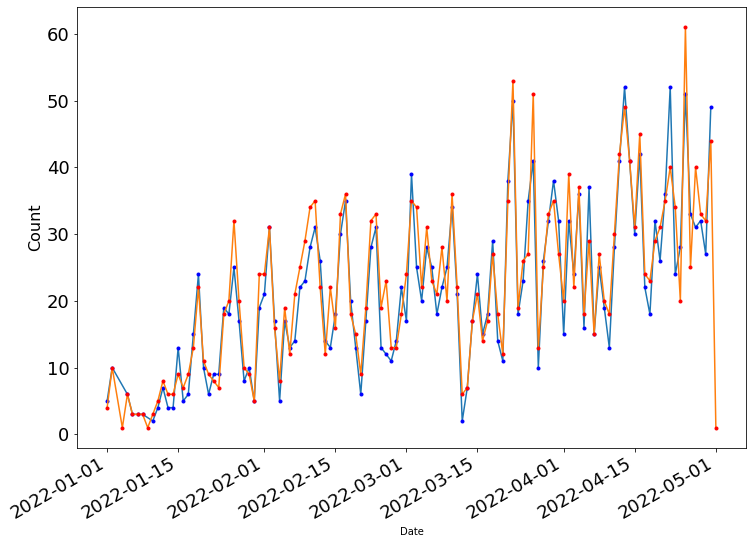

In [283]:
fig, ax1 = plt.subplots(figsize=(12, 9))
ax1.plot_date( df_pu['started_at_date'], df_pu['pu_ct'],linestyle = 'solid',markeredgecolor = 'blue',markerfacecolor = 'blue', markersize = 3)
ax1.plot_date( df_do['ended_at_date'], df_do['do_ct'],linestyle = 'solid',markeredgecolor = 'red',markerfacecolor = 'red', markersize = 3)

ax1.set_xlabel('Date',fontsize=10)
ax1.set_ylabel('Count',fontsize=16)
plt.gcf().autofmt_xdate()

plt.tick_params(labelsize=18)
plt.show()  

## Weather Data

In [284]:
df_weather = pd.read_csv('Data/DC Weather 2022-01-01 to 2022-12-31.csv')

df_weather.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Washington,DC,USA",2022-01-01,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,...,0.6,0,NaN,2022-01-01T07:26:53,2022-01-01T16:56:53,0.99,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,A..."
1,"Washington,DC,USA",2022-01-02,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,...,1.7,1,NaN,2022-01-02T07:27:00,2022-01-02T16:57:43,1.00,"Rain, Overcast",Cloudy skies throughout the day with rain clea...,rain,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,7..."
2,"Washington,DC,USA",2022-01-03,46.0,26.1,32.7,39.4,14.3,23.0,26.6,78.7,...,0.0,0,NaN,2022-01-03T07:27:05,2022-01-03T16:58:34,0.00,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,snow,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,A..."
3,"Washington,DC,USA",2022-01-04,34.0,25.3,29.4,33.7,16.0,24.0,19.2,65.7,...,5.4,6,NaN,2022-01-04T07:27:07,2022-01-04T16:59:27,0.02,Clear,Clear conditions throughout the day.,snow,"KDCA,72405013743,72403793728,D6279,F0198,KADW,..."
4,"Washington,DC,USA",2022-01-05,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,...,2.2,1,NaN,2022-01-05T07:27:08,2022-01-05T17:00:21,0.05,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,7..."


## Check missing values

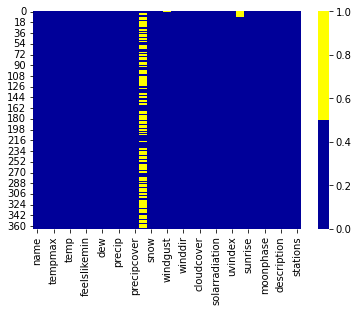

In [285]:
# Date time format 
df_weather['datetime'] = pd.to_datetime(df_weather['datetime']).dt.date

# Use sns heatmap to see whats are the null values.
coln = df_weather.columns[:df_weather.shape[1]]  
colors = ['#000099','#ffff00'] # specify the colors - yellow is missing. blue is not missing.
sns.heatmap(df_weather[coln].isnull(), cmap = sns.color_palette(colors))
plt.show()

## Drop variables of your choice

In [286]:
# Drop unnecessary variables
df_weather=df_weather.drop(columns=['name', 'stations','description','sunrise','sunset','conditions','severerisk','preciptype','windgust'])

## Prepare X and y: Merge weather data with trip data

In [287]:
# Merge with weather data and remove dates and station name

df_m_pu = df_pu.merge(df_weather, left_on='started_at_date', right_on='datetime') 
df_m_pu = df_m_pu.drop(columns=['started_at_date','start_station_name','datetime'])
df_m_do = df_do.merge(df_weather, left_on='ended_at_date', right_on='datetime') 
df_m_do = df_m_do.drop(columns=['ended_at_date','end_station_name','datetime'])

In [288]:
df_m_pu.head()

,pu_ct,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon
0,5,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,0.448,...,11.4,190.2,1007.2,99.5,6.2,21.4,0.6,0,0.99,rain
1,10,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,0.124,...,18.9,290.7,1006.6,91.6,9.6,47.3,1.7,1,1.00,rain
2,6,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,0.000,...,13.6,195.2,1014.5,82.6,9.9,63.5,2.2,1,0.05,partly-cloudy-day
3,3,42.9,36.9,39.8,40.6,29.5,35.3,24.2,55.0,0.000,...,12.9,16.0,1012.7,88.1,9.9,145.6,5.3,4,0.09,snow
4,3,35.8,24.9,29.8,26.4,16.7,20.0,15.3,56.2,0.118,...,21.3,313.3,1018.6,58.4,8.4,180.5,6.7,5,0.14,snow


# Demo: train linear models

In [289]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [290]:
# pickup
y = df_m_pu['pu_ct']
X = df_m_pu.drop('pu_ct',axis=1)
X = pd.get_dummies(data=X, drop_first=True)
X.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon_partly-cloudy-day,icon_rain,icon_snow,icon_wind
0,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,0.448,100,...,99.5,6.2,21.4,0.6,0,0.99,0,1,0,0
1,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,0.124,100,...,91.6,9.6,47.3,1.7,1,1.00,0,1,0,0
2,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,0.000,0,...,82.6,9.9,63.5,2.2,1,0.05,1,0,0,0
3,42.9,36.9,39.8,40.6,29.5,35.3,24.2,55.0,0.000,0,...,88.1,9.9,145.6,5.3,4,0.09,0,0,1,0
4,35.8,24.9,29.8,26.4,16.7,20.0,15.3,56.2,0.118,100,...,58.4,8.4,180.5,6.7,5,0.14,0,0,1,0


In [291]:
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.4, random_state = 200)

## Linear Regression

In [292]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train) 
y_pred = linear_regressor.predict(X_test)

In [293]:
print(pd.Series(linear_regressor.coef_.flatten(), index=X_train.columns))

tempmax                    0.207164
tempmin                   -0.373107
temp                       2.260221
feelslikemax              -0.556019
feelslikemin               0.027178
feelslike                 -1.798180
dew                        1.234439
humidity                  -0.748718
precip                   -18.105795
precipprob                 0.033251
precipcover                0.229247
snow                      -1.909278
snowdepth                 10.820056
windspeed                 -1.338493
winddir                    0.005234
sealevelpressure          -0.129811
cloudcover                 0.157089
visibility                -0.254753
solarradiation            -0.490021
solarenergy                6.691056
uvindex                    0.864172
moonphase                  2.121332
icon_partly-cloudy-day    -2.600266
icon_rain                 -3.477979
icon_snow                -14.747586
icon_wind                 20.825832
dtype: float64


In [294]:
mse = round(mean_squared_error(y_test, y_pred),3)
print(f"MSE is {mse}")

MSE is 191.181


## LASSO

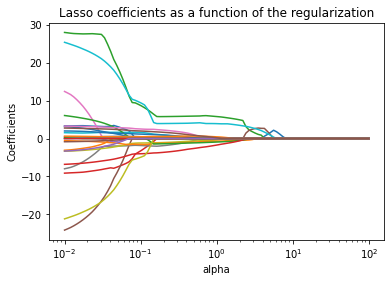

In [295]:
alphas = 10**np.linspace(-2,2,100)

lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a, max_iter=10000) # increase iterations for optimization of coefficients
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
# plt.legend(list(X_train.columns), loc='best')

plt.title('Lasso coefficients as a function of the regularization');

In [296]:
# find the best alpha via CV with selected scoring metric
lassocv = LassoCV(alphas=alphas, max_iter=10000)
lassocv.fit(scale(X_train), y_train)

print('The best alpha from LassoCV:', lassocv.alpha_)

The best alpha from LassoCV: 0.8697490026177834


In [297]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X_train.columns))

The coefficients are:
tempmax                   0.000000
tempmin                   0.000000
temp                      5.901848
feelslikemax              0.000000
feelslikemin              0.000000
feelslike                 0.000000
dew                       0.000000
humidity                 -0.000000
precip                   -0.461702
precipprob                0.000000
precipcover              -0.000000
snow                     -0.753285
snowdepth                -0.982580
windspeed                -1.931835
winddir                  -0.000000
sealevelpressure         -0.000000
cloudcover                0.000000
visibility                0.045851
solarradiation            0.000000
solarenergy               3.950346
uvindex                   0.000000
moonphase                 0.510716
icon_partly-cloudy-day    0.000000
icon_rain                 0.000000
icon_snow                -0.000000
icon_wind                 0.355107
dtype: float64


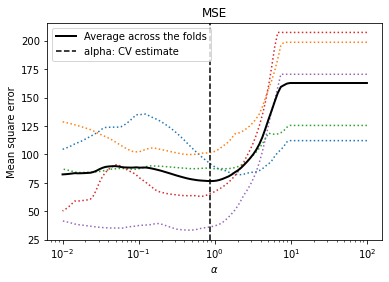

In [298]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, linestyle=":")
plt.plot(
    lassocv.alphas_,
    lassocv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")


plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("MSE")
plt.show()

In [299]:
y_pred=lasso.predict(scale(X_test.values))
mse = round(mean_squared_error(y_test, y_pred),3)
print(f"MSE is {mse}")

MSE is 76.788


## You will try other methods (e.g., KNN) and tune hyperparameters when necessary